In [185]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import sys
from torch.autograd import Variable

sys.path.append('..')
sys.path.append('../visualization')
sys.path.append('../acd/util')
sys.path.append('../acd/scores')
sys.path.append('../acd/agglomeration')
import viz_1d as viz
import tiling_1d as tiling
import agg_1d as agg
import cd
import score_funcs


# form class to hold data
class B:
    def __init__(self):
        self.text = Variable(torch.zeros(1))

sys.path.append('../dsets/sst')
import dset
sst_pkl = pickle.load(open('../dsets/sst/sst.pkl', 'rb'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load model

In [186]:
snapshot_file = '../dsets/sst/sst.model'
model = dset.get_model(snapshot_file, cpu=True).eval()
model.use_gpu = False

embed = model.embed.weight.data.numpy() 
unk_embed = np.reshape(embed[0], (1, len(embed[0])))
embed = np.concatenate([embed, unk_embed], 0)
x, y = embed.shape
model.embed = torch.nn.Embedding(x, y)
model.embed.weight.data.copy_(torch.from_numpy(embed))

loading ../dsets/sst/sst.model
loaded onto cpu...


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model.LSTMSentiment' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)



 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
-0.0152  0.0062 -0.0191  ...  -0.0322 -0.0299  0.0433
 0.0171  0.1844 -0.0194  ...   0.0533 -0.1989  0.0472
          ...             ⋱             ...          
 0.0206 -0.2081  0.4568  ...   0.4254  0.2714 -0.1388
-0.0259  0.3129  0.1854  ...   0.5867 -0.1528 -0.7230
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
[torch.FloatTensor of size 18845x300]

# run examples

../dsets/sst/model.py:29: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  lstm_out, self.hidden = self.lstm(vecs, self.hidden)
../acd/agglomeration/agg_1d.py:31: RuntimeWarning: invalid value encountered in greater_equal
  mask = scores >= thresh
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


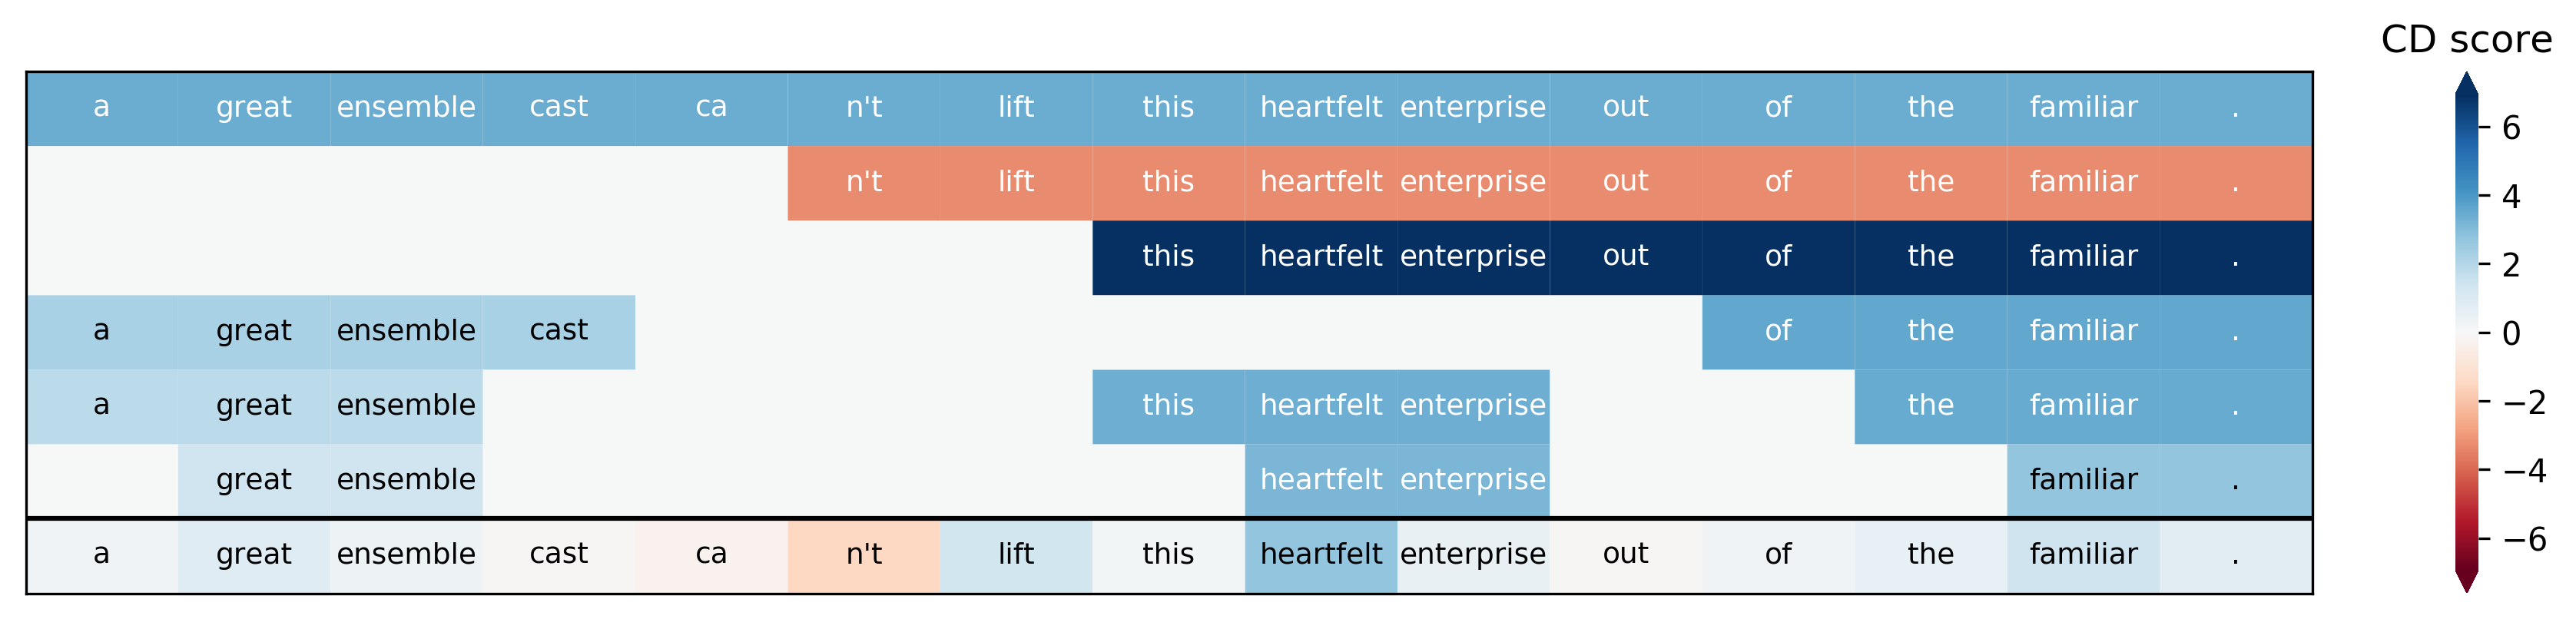

In [108]:
# base parameters
sweep_dim = 1 # how large chunks of text should be considered (1 for words)
method = 'cd' # build_up, break_down, cd
percentile_include = 99.5 # keep this very high so we don't add too many words at once
num_iters = 25 # maximum number of iterations (rarely reached)

# text and label
sentence = ['a', 'great', 'ensemble', 'cast', 'ca', 'n\'t', 'lift', 'this', 'heartfelt', 'enterprise', 'out', 'of', 'the', 'familiar', '.'] # note this is a real example from the dataset
# sentence = ['not', 'good', ',', 'not', 'bad', ',', 'just', 'okay'] # any text with words from this dataset can be interpreted
label = 0 # 0 if positive 1 if negative


def batch_from_str_list(s):
    batch = B()
    nums = np.expand_dims(np.array([sst_pkl['stoi'].get(x, len(sst_pkl['stoi'])) for x in s]).transpose(), axis=1)
    batch.text.data = torch.LongTensor(nums)
    return batch

# prepare inputs
batch = batch_from_str_list(sentence)
scores_all = model(batch).data.numpy()[0] # predict
label_pred = np.argmax(scores_all) # get predicted class

# agglomerate
lists = agg.agglomerate(model, batch, percentile_include, method, sweep_dim, # only works for sweep_dim = 1
                    sentence, label_pred, num_iters=num_iters) # see agg_1d.agglomerate to understand what this dictionary contains
lists = agg.collapse_tree(lists) # don't show redundant joins

# visualize
viz.word_heatmap(sentence, lists, label_pred, label, fontsize=9)

In [5]:
lists

{'scores_list': [array([ 0.27162706,  0.85409233,  0.37806375, -0.05415723, -0.31606592,
         -1.42193544,  1.31264514,  0.18296385,  2.73652586,  0.52970585,
         -0.08850623,  0.27953949,  0.55982536,  1.41685143,  0.80828439]),
  array([ 0.27162706,  0.85409233,  0.37806375, -0.05415723, -0.31606592,
         -1.42193544,  1.31264514,  0.17367754,         nan,  0.45062705,
         -0.08850623,  0.27953949,  0.55982536,  1.41685143,  0.80828439]),
  array([ 0.27162706,  0.85409233,  0.37806375, -0.05415723,  0.03769391,
                 nan, -0.10645588,  0.17367754,         nan,  0.45062705,
         -0.08850623,  0.27953949,  0.55982536,  1.41685143,  0.80828439]),
  array([ 0.27162706,  0.85409233,  0.37806375, -0.05415723,  0.03769391,
                 nan, -0.10645588,  0.17367754,         nan,  0.45062705,
         -0.08850623,  0.27953949,  0.56959644,         nan,  1.31289618]),
  array([ 0.27162706,  0.85409233,  0.37806375, -0.05415723,  0.03769391,
               

In [26]:
len(lists['scores_list'])

15

In [10]:
len(lists['mask_list'])

15

In [13]:
len(lists['comps_list'])

7

In [14]:
len(lists['comp_scores_list'])

7

## Notes

`lists['scores_list']` is a list of shape `(num_words, num_words)`  (at least the 2nd dimension is definitely number of words). This is only used once to retrieve word-level score.

`data` is a numpy array of np.nan, shape of `(num_iters, num_words)`

The visualizer iterates through the `num_iters`, and pair up `lists['comps_list]` and `lists['comp_scores_list']`. The index in `lists['comps_list]` like `3 3` corresponds to the **3rd** value in `lists['comp_scores_list']`.

In [19]:
# Here we try to retrace the visualization to see how this list is used
# No need to "crack" ACD right now, but to just morph the pumped out data to a binary tree

num_words = len(sentence)
num_iters = len(lists['comps_list'])
data = np.zeros(shape=(num_iters, num_words))

In [21]:
data[:] = np.nan

In [22]:
lists['scores_list'][0]

array([ 0.27162706,  0.85409233,  0.37806375, -0.05415723, -0.31606592,
       -1.42193544,  1.31264514,  0.18296385,  2.73652586,  0.52970585,
       -0.08850623,  0.27953949,  0.55982536,  1.41685143,  0.80828439])

In [27]:
data[0, :] = lists['scores_list'][0]

In [32]:
for i in range(1, num_iters):
    print("iteration {}".format(i))
    print(lists['comps_list'][i])
    print(lists['comp_scores_list'][i])

iteration 1
[0 3 3 0 0 0 0 0 5 5 0 0 0 2 2]
{0: 0, 1: array(2.72974761), 2: array(2.72974761), 3: array(1.3827072), 4: array(3.18715291), 5: array(3.18715291)}
iteration 2
[5 5 5 0 0 0 0 8 8 8 0 0 7 7 7]
{0: 0, 1: array(3.49616667), 2: array(3.49616667), 3: array(1.8660471), 4: array(3.49616667), 5: array(1.8660471), 6: array(3.49616667), 7: array(3.49616667), 8: array(3.3583604)}
iteration 3
[5 5 5 5 0 0 0 0 0 0 0 3 3 3 3]
{0: 0, 1: array(2.26526034), 2: array(2.26526034), 3: array(3.61269206), 4: array(2.26526034), 5: array(2.26526034)}
iteration 4
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
{0: 0, 1: array(6.91574338)}
iteration 5
[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
{0: 0, 1: array(-3.24209191)}
iteration 6
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
{0: 0, 1: array(3.45496851)}


In [50]:
for i in range(1, num_iters):
    comps = lists['comps_list'][i]
    comp_scores_list = lists['comp_scores_list'][i]

    for comp_num in range(1, np.max(comps) + 1):
        idxs = comps == comp_num
        data[i][idxs] = comp_scores_list[comp_num]

In [51]:
data

array([[ 0.27162706,  0.85409233,  0.37806375, -0.05415723, -0.31606592,
        -1.42193544,  1.31264514,  0.18296385,  2.73652586,  0.52970585,
        -0.08850623,  0.27953949,  0.55982536,  1.41685143,  0.80828439],
       [        nan,  1.3827072 ,  1.3827072 ,         nan,         nan,
                nan,         nan,         nan,  3.18715291,  3.18715291,
                nan,         nan,         nan,  2.72974761,  2.72974761],
       [ 1.8660471 ,  1.8660471 ,  1.8660471 ,         nan,         nan,
                nan,         nan,  3.3583604 ,  3.3583604 ,  3.3583604 ,
                nan,         nan,  3.49616667,  3.49616667,  3.49616667],
       [ 2.26526034,  2.26526034,  2.26526034,  2.26526034,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,  3.61269206,  3.61269206,  3.61269206,  3.61269206],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,  6.91574338, 

Let's recreate this

[0 3 3 0 0 0 0 0 5 5 0 0 0 2 2]

[5 5 5 0 0 0 0 8 8 8 0 0 7 7 7]

[5 5 5 5 0 0 0 8 8 8 0 3 3 3 3]

[5 5 5 5 0 0 0 1 1 1 1 1 1 1 1]

[5 5 5 5 0 1 1 1 1 1 1 1 1 1 1]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

All we need to do is take in `lists['comps_list']` and `lists['comp_scores_list']`, and churn out a tree.

NLTK has this: http://www.nltk.org/_modules/nltk/treetransforms.html

Tutorials on trees:

https://www.nltk.org/_modules/nltk/tree.html

http://www.nltk.org/howto/tree.html

We first see if NLTK will parse SST-like trees

In [33]:
sst_sent = "(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))"

In [36]:
from nltk import Tree
tree = Tree.fromstring(sst_sent)
tree.pretty_print()

              3                                                                     
  ____________|____________________                                                  
 |                                 4                                                
 |        _________________________|______________________________________________   
 |       4                                                                        | 
 |    ___|______________                                                          |  
 |   |                  4                                                         | 
 |   |         _________|__________                                               |  
 |   |        |                    3                                              | 
 |   |        |               _____|______________________                        |  
 |   |        |              |                            4                       | 
 |   |        |              |            ________________|_

We can recursively build up NLTK tree, and use the below command to turn into string representation

In [49]:
parse_string = ' '.join(str(tree).split()) 

print(parse_string)

print(parse_string == sst_sent)

(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))
True


NLTK trees can be built recursively upward:

`Tree(parent, [childrens])`

Procedures:
1. At leaf-level, each child node (words) has parent that is their CD value
2. Or we can try from top to bottom

In [69]:
for i in range(0, num_iters):
    print("iteration {}".format(i))
    print(lists['comps_list'][i])
    print(lists['comp_scores_list'][i])

iteration 0
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
{0: 0}
iteration 1
[0 3 3 0 0 0 0 0 5 5 0 0 0 2 2]
{0: 0, 1: array(2.72974761), 2: array(2.72974761), 3: array(1.3827072), 4: array(3.18715291), 5: array(3.18715291)}
iteration 2
[5 5 5 0 0 0 0 8 8 8 0 0 7 7 7]
{0: 0, 1: array(3.49616667), 2: array(3.49616667), 3: array(1.8660471), 4: array(3.49616667), 5: array(1.8660471), 6: array(3.49616667), 7: array(3.49616667), 8: array(3.3583604)}
iteration 3
[5 5 5 5 0 0 0 0 0 0 0 3 3 3 3]
{0: 0, 1: array(2.26526034), 2: array(2.26526034), 3: array(3.61269206), 4: array(2.26526034), 5: array(2.26526034)}
iteration 4
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
{0: 0, 1: array(6.91574338)}
iteration 5
[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
{0: 0, 1: array(-3.24209191)}
iteration 6
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
{0: 0, 1: array(3.45496851)}


In [ ]:
for i in range(0, num_iters):
    print("iteration {}".format(i))
    print(lists['comps_list'][i])
    print(lists['comp_scores_list'][i])

In [130]:
for i in range(1, num_iters):
    print(lists['comps_list'][i])

[0 3 3 0 0 0 0 0 5 5 0 0 0 2 2]
[5 5 5 0 0 0 0 8 8 8 0 0 7 7 7]
[5 5 5 5 0 0 0 0 0 0 0 3 3 3 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [135]:
from copy import copy
prev_list = None
for i in range(1, num_iters):
    cur_list = copy(lists['comps_list'][i])
    if prev_list is None:
        print(cur_list)
    else:
        for j in range(0, num_words):
            if prev_list[j] != 0 and cur_list[j] == 0:
                cur_list[j] = 9
        print(cur_list)

    # do something here
    prev_list = cur_list

[0 3 3 0 0 0 0 0 5 5 0 0 0 2 2]
[5 5 5 0 0 0 0 8 8 8 0 0 7 7 7]
[5 5 5 5 0 0 0 9 9 9 0 3 3 3 3]
[9 9 9 9 0 0 0 1 1 1 1 1 1 1 1]
[9 9 9 9 0 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [163]:
def word_score_list_to_comp_score_list(orig_word_socres_list):
    # turn numpy array [word-score-1, word-score-2, ..]
    # into dictionary {1: word-score-1, 2: word-score-2, ...}
    comp_scores_list = {}
    for i in range(0, orig_word_socres_list.size):
        comp_scores_list[i] = orig_word_socres_list[i]
    return comp_scores_list

def build_leaf_nodes(word_socres_list, sent):
    nodes = []
    for i in range(len(word_socres_list)):
        nodes.append(Tree("{:.2f}".format(word_socres_list[i]), [sent[i]]))
    return nodes

def tree_to_str(tree):
    parse_string = ' '.join(str(tree).split()) 
    return parse_string

from copy import copy

def fill_comp_list_w_previous(lists, num_words, filler_index=-1):
    # comps_list only record change (probably collapsed)
    
    num_iters = len(lists['comps_list'])
    new_comp_scores_list = [lists['comps_list'][0]]
    
    prev_list = None
    for i in range(1, num_iters):
        cur_list = copy(lists['comps_list'][i])
        if prev_list is None:
            new_comp_scores_list.append(cur_list)
        else:
            for j in range(0, num_words):
                if prev_list[j] != 0 and cur_list[j] == 0:
                    cur_list[j] = filler_index
            new_comp_scores_list.append(cur_list)

        prev_list = cur_list
    
    return new_comp_scores_list

from copy import deepcopy, copy
from nltk import Tree
def comp_to_tree(lists, sent, binarize=True):
    # return a parentheses based tree representation
    # NLTK will transform it into a binary tree. We go with left-branching for non-binary nodes
    # sent: a list of words
    # binarize=True: we use left binarization
    # main logic: we replicate the tree to fill the position of children!
    
    word_socres_list = word_score_list_to_comp_score_list(lists['scores_list'][0])
    
    children = build_leaf_nodes(word_socres_list, sent)
    
    """
      array([0, 0, 0, 0, 1, 1, 0, 0]),
      array([0, 0, 0, 0, 1, 1, 1, 0]),
      array([0, 0, 0, 1, 1, 1, 1, 1]),
      array([0, 0, 1, 1, 1, 1, 1, 1]),
      array([0, 1, 1, 1, 1, 1, 1, 1]),
      array([1, 1, 1, 1, 1, 1, 1, 1])],
    """
        
    num_iters = len(lists['comps_list'])
    num_words = len(sent)
    
    comps_list = fill_comp_list_w_previous(lists, num_words)
    
    prev_level = None
    for i in range(1, num_iters):
        comps = comps_list[i] # lists['comps_list'][i]
        comp_scores = lists['comp_scores_list'][i]
        
        # print(comps)
        
        # only at first level
        if prev_level is None:
            # we build at each level
            # [2 3 5], we ignore 0
            u_values = np.unique(comps[comps.nonzero()])
            # We build parent node, and then replace the children node
            # [0 1 2 3 ... 14] -> [0 t1 t1 3 ... 14]
            for v in u_values:
                # these two children are merged!
                child_indices = np.nonzero(comps == v)[0]
                # print("{}: {}".format(v, child_indices))
                parent_val = comp_scores[v]
                parent = Tree("{:.2f}".format(parent_val), [children[j] for j in child_indices])
                for c_i in child_indices:
                    children[c_i] = parent # copy(parent)
        else:
            # we compare difference between prev_level and current level
            # and only merge the difference
            carry_over_words = []
            for j in range(0, num_words):
                if comps[j] != 0 and prev_level[j] == 0: # current build has a difference now
                    parent_val = comp_scores[comps[j]]
                    # now we check, for the prev_level, if this comps[j] is to left group or right group
                    # or both, if both, we construct a three nodes branch
                    prev_merge_idices = None
                    if j == 0:  # first word
                        parent = Tree("{:.2f}".format(parent_val), [children[j], children[j+1]])
                        prev_merge_idices = [j+1]
                    elif j == num_words - 1:  # last word
                        parent = Tree("{:.2f}".format(parent_val), [children[j-1], children[j]])
                        prev_merge_idices = [j-1]
                    elif prev_level[j-1] != 0 and prev_level[j+1] != 0:
                        parent = Tree("{:.2f}".format(parent_val), [children[j-1]] + carry_over_words + [children[j], children[j+1]])
                        carry_over_words = []
                        prev_merge_idices = [j-1, j+1]
                    elif prev_level[j-1] != 0:
                        parent = Tree("{:.2f}".format(parent_val), [children[j-1], children[j]])
                        prev_merge_idices = [j-1]
                    elif prev_level[j+1] != 0:
                        parent = Tree("{:.2f}".format(parent_val), carry_over_words + [children[j], children[j+1]])
                        carry_over_words = []
                        prev_merge_idices = [j+1]
                    else:
                        #print("j: {}".format(j))
                        #print("prev: {}".format(prev_level))
                        #print("cur: {}".format(comps))
                        # this is the case where there are more than 1 item to join! 
                        carry_over_words.append(children[j])
                        continue

                    # child_indices = np.nonzero(comps == comps[j])[0]  # new group
                    # however, child_indices could include a future j that's not in previous 
                    
                    """
                      Need to handle this!
                      
                      array([0, 0, 0, 0, 1, 1, 1, 0]),
                      array([0, 0, 0, 1, 1, 1, 1, 1]),
                    """
                    
                    # only update one that's in prev_nodes
                    for prev_merge_i in prev_merge_idices:
                        child_indices = np.nonzero(prev_level == prev_level[prev_merge_i])[0]
                        for c_i in child_indices:
                            children[c_i] = parent
                        # as a check, we see if the new list has elements not in prev_level, and it's earlier
                        new_indices = np.nonzero(comps == comps[j])[0]
                        for past_retro_update_i in new_indices:
                            if past_retro_update_i < j:
                                children[past_retro_update_i] = parent
                    
                    # update the node itself
                    children[j] = parent

#         if i == 3:
#             break
        prev_level = comps
                
    return children

In [160]:
print(sentence)

['Yet', 'the', 'act', 'is', 'still', 'charming', 'here', '.']


In [162]:
children = comp_to_tree(lists, sentence)
children[0].pretty_print()

     7.55                                          
  ____|_____                                        
 |         8.12                                    
 |     _____|___________                            
 |    |                8.02                        
 |    |      ___________|___________                
 |    |     |                      8.46            
 |    |     |                 ______|___________    
 |    |     |               8.46                |  
 |    |     |      __________|______            |   
 |    |     |     |                6.06         |  
 |    |     |     |           ______|______     |   
 |    |     |     |         5.35           |    |  
 |    |     |     |      ____|______       |    |   
0.00 0.02 -0.15 -0.17  0.23        4.73   0.61 0.47
 |    |     |     |     |           |      |    |   
Yet  the   act    is  still      charming here  .  



In [75]:
children = comp_to_tree(lists, sentence)

In [76]:
tree_to_str(children[0])

"(3.45 (2.27 (1.87 (0.27 a) (1.38 (0.85 great) (0.38 ensemble))) (-0.05 cast)) (-0.32 ca) (-3.24 (-1.42 n't) (1.31 lift) (6.92 (3.36 (0.18 this) (3.19 (2.74 heartfelt) (0.53 enterprise))) (-0.09 out) (3.61 (0.28 of) (3.50 (0.56 the) (2.73 (1.42 familiar) (0.81 .)))))))"

In [78]:
children[0].pretty_print()

                                                3.45                                                                  
             ____________________________________|______________________                                               
            |                    |                                    -3.24                                           
            |                    |      ________________________________|________                                      
            |                    |     |    |                                   6.92                                  
            |                    |     |    |             _______________________|______________                       
           2.27                  |     |    |            |                       |             3.61                   
        ____|______________      |     |    |            |                       |     _________|______                
      1.87                 |     |     |    

In [80]:
from nltk import treetransforms
collapsedTree = deepcopy(children[0])
treetransforms.collapse_unary(collapsedTree)

cnfTree = deepcopy(collapsedTree)
chomsky_normal_form(cnfTree, factor='left')

In [102]:
# convert the tree to CNF
cnfTree = deepcopy(collapsedTree)
chomsky_normal_form(cnfTree, factor='left')

In [103]:
tree_to_str(cnfTree)

"(3.45 (3.45 (2.27 (1.87 (0.27 a) (1.38 (0.85 great) (0.38 ensemble))) (-0.05 cast)) (-0.32 ca)) (-3.24 (-3.24 (-1.42 n't) (1.31 lift)) (6.92 (6.92 (3.36 (0.18 this) (3.19 (2.74 heartfelt) (0.53 enterprise))) (-0.09 out)) (3.61 (0.28 of) (3.50 (0.56 the) (2.73 (1.42 familiar) (0.81 .)))))))"

In [104]:
cnfTree.pretty_print()

                                                      3.45                                                                  
                    ___________________________________|______________________                                               
                   |                                                        -3.24                                           
                   |                          ________________________________|________                                      
                  3.45                       |                                        6.92                                  
             ______|_____________            |                         ________________|______________                       
           2.27                  |           |                       6.92                            3.61                   
        ____|______________      |           |                  ______|________________      _________|______             

In [92]:
def chomsky_normal_form(tree, factor="right", horzMarkov=None, vertMarkov=0, childChar="|", parentChar="^"):
    # assume all subtrees have homogeneous children
    # assume all terminals have no siblings

    # A semi-hack to have elegant looking code below.  As a result,
    # any subtree with a branching factor greater than 999 will be incorrectly truncated.
    if horzMarkov is None: horzMarkov = 999

    # Traverse the tree depth-first keeping a list of ancestor nodes to the root.
    # I chose not to use the tree.treepositions() method since it requires
    # two traversals of the tree (one to get the positions, one to iterate
    # over them) and node access time is proportional to the height of the node.
    # This method is 7x faster which helps when parsing 40,000 sentences.

    nodeList = [(tree, [tree.label()])]
    while nodeList != []:
        node, parent = nodeList.pop()
        if isinstance(node,Tree):

            # parent annotation
            parentString = ""
            originalNode = node.label()
            if vertMarkov != 0 and node != tree and isinstance(node[0],Tree):
                parentString = "%s<%s>" % (parentChar, "-".join(parent))
                node.set_label(node.label()) # + parentString
                parent = [originalNode] + parent[:vertMarkov - 1]

            # add children to the agenda before we mess with them
            for child in node:
                nodeList.append((child, parent))

            # chomsky normal form factorization
            if len(node) > 2:
                childNodes = [child.label() for child in node]
                nodeCopy = node.copy()
                node[0:] = [] # delete the children

                curNode = node
                numChildren = len(nodeCopy)
                for i in range(1,numChildren - 1):
                    if factor == "right":
                        newHead = "%s" % originalNode # "%s%s<%s>%s" % (originalNode, childChar, "-".join(childNodes[i:min([i+horzMarkov,numChildren])]),parentString) # create new head
                        newNode = Tree(newHead, [])
                        curNode[0:] = [nodeCopy.pop(0), newNode]
                    else:
                        newHead = "%s" % originalNode
                        # newHead = "%s%s<%s>%s" % (originalNode, childChar, "-".join(childNodes[max([numChildren-i-horzMarkov,0]):-i]),parentString)
                        newNode = Tree(newHead, [])
                        curNode[0:] = [newNode, nodeCopy.pop()]

                    curNode = newNode

                curNode[0:] = [child for child in nodeCopy]

We will try on another example!

## Debug log

CD's current code cannot handle out-of-vocabulary words (OOV)

because OOV is 0, so the `tiles_to_cd()` method in `score_funcs.py` will break

In [69]:
%pdb 0

Automatic pdb calling has been turned OFF


../dsets/sst/model.py:29: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  lstm_out, self.hidden = self.lstm(vecs, self.hidden)
../acd/agglomeration/agg_1d.py:31: RuntimeWarning: invalid value encountered in greater_equal
  mask = scores >= thresh
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


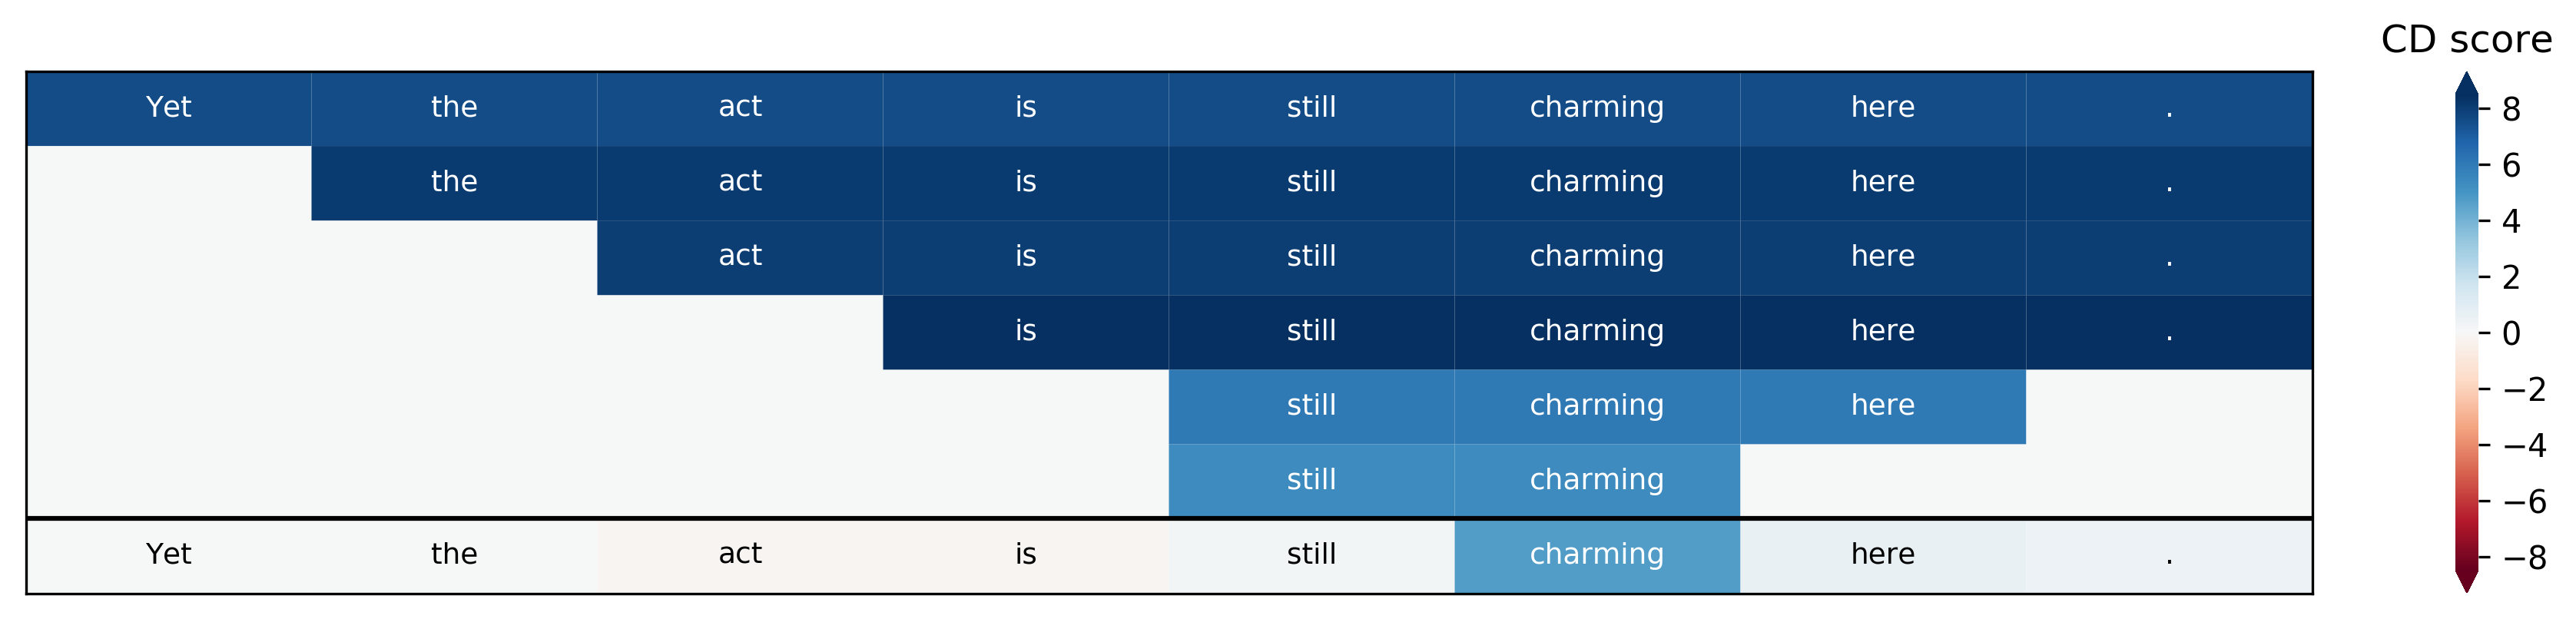

In [109]:
# base parameters
sweep_dim = 1 # how large chunks of text should be considered (1 for words)
method = 'cd' # build_up, break_down, cd
percentile_include = 99.5 # keep this very high so we don't add too many words at once
num_iters = 25 # maximum number of iterations (rarely reached)

# text and label
sentence = ['it', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.']
sentence = ['Yet', 'the', 'act', 'is', 'still', 'charming', 'here', '.']
# sentence = ['a', 'great', 'ensemble', 'cast', 'ca', 'n\'t', 'lift', 'this', 'heartfelt', 'enterprise', 'out', 'of', 'the', 'familiar', '.'] 
label = 0 # 0 if positive 1 if negative

def batch_from_str_list(s):
    batch = B()
    nums = np.expand_dims(np.array([sst_pkl['stoi'].get(x, len(sst_pkl['stoi'])) for x in s]).transpose(), axis=1)
    batch.text.data = torch.LongTensor(nums)
    return batch

# prepare inputs
batch = batch_from_str_list(sentence)
scores_all = model(batch).data.numpy()[0] # predict
label_pred = np.argmax(scores_all) # get predicted class

# agglomerate
lists = agg.agglomerate(model, batch, percentile_include, method, sweep_dim, # only works for sweep_dim = 1
                    sentence, label_pred, num_iters=num_iters) # see agg_1d.agglomerate to understand what this dictionary contains
lists = agg.collapse_tree(lists) # don't show redundant joins

# visualize
viz.word_heatmap(sentence, lists, label_pred, label, fontsize=9)

In [126]:
lists

{'scores_list': [array([ 2.69438625e-09,  2.40957365e-02, -1.53728961e-01, -1.67929049e-01,
          2.28189781e-01,  4.72716698e+00,  6.08240756e-01,  4.67974354e-01]),
  array([ 2.69438625e-09,  2.40957365e-02, -1.53728961e-01, -1.67929049e-01,
          6.27572155e-01,             nan,  5.84552204e-01,  4.67974354e-01]),
  array([ 2.69438625e-09,  2.40957365e-02, -1.53728961e-01,  1.06333764e-01,
                     nan,             nan,  7.01393751e-01,  4.67974354e-01]),
  array([ 2.69438625e-09,  2.40957365e-02, -1.53728961e-01,  1.94506908e-01,
                     nan,             nan,             nan,  2.06142814e+00]),
  array([ 2.69438625e-09,  2.40957365e-02, -4.41146281e-01,             nan,
                     nan,             nan,             nan,             nan]),
  array([2.69438625e-09, 9.98816869e-02,            nan,            nan,
                    nan,            nan,            nan,            nan]),
  array([-0.56732489,         nan,         nan,         n

In [125]:
children = comp_to_tree(lists, sentence)
children[0].pretty_print()

     7.55                                                                    
  ____|_____                                                                  
 |         8.12                                                              
 |     _____|___________                                                      
 |    |                8.02                                                  
 |    |      ___________|__________________                                   
 |    |     |                             8.46                               
 |    |     |                 _____________|________________                  
 |    |     |               8.46                           8.46              
 |    |     |      __________|______              __________|______           
 |    |     |     |                6.06          |                6.06       
 |    |     |     |           ______|______      |           ______|______    
 |    |     |     |         5.35           |     |        

## Preprocess SST

We preprocess SST, and use model to interpret, algorithm to parse into a tree

In [110]:
sst_path = "../data/sst/trees/"
train_path = sst_path + "train.txt"
dev_path = sst_path + "dev.txt"
test_path = sst_path + "test.txt"

In [115]:
from nltk import Tree

def get_sentences(path):
    sents = []
    with open(path, 'r') as f:
        for line in f:
            sent = Tree.fromstring(line.strip()).leaves()
            sents.append(sent)
    return sents

In [116]:
train_sents = get_sentences(train_path)

In [117]:
dev_sents = get_sentences(dev_path)
test_sents = get_sentences(test_path)

In [204]:
sents = """
        I would mark this as the right answer. The alternative inline works, 
        but greets you with the following warning: Starting all kernels in pylab mode is not 
        recommended, and will be disabled in a future release. Please use the magic to enable matplotlib 
        instead. 
        """.split()
len(sents)

44

In [214]:
def batch_from_str_list(s):
    batch = B()
    nums = np.expand_dims(np.array([sst_pkl['stoi'].get(x, len(sst_pkl['stoi'])) for x in s]).transpose(), axis=1)
    batch.text.data = torch.LongTensor(nums)
    return batch

from nltk import treetransforms

import time

def transform_sst_to_acd_trees(sents, binarize=True, filter_len=20):
    # base parameters
    sweep_dim = 1 # how large chunks of text should be considered (1 for words)
    method = 'cd' # build_up, break_down, cd
    percentile_include = 99.5 # keep this very high so we don't add too many words at once
    num_iters = 25 # maximum number of iterations (rarely reached)

    new_data = []
    cnt = time.time()
    
    for s_i, sent in enumerate(sents):
        # prepare inputs
        #print(len(sent))
        if s_i % 10 == 0:
            print("time {} processed {}".format(time.time() - cnt, s_i))
            
        if len(sent) > filter_len:
            continue
        #print("{} time {} - 0".format(s_i, time.time() - cnt))
        #cnt = time.time()
        batch = batch_from_str_list(sent)
        scores_all = model(batch).data.numpy()[0] # predict
        label_pred = np.argmax(scores_all) # get predicted class

        # agglomerate
        #print("{} time {} - 1".format(s_i, time.time() - cnt))
        #cnt = time.time()
        lists = agg.agglomerate(model, batch, percentile_include, method, sweep_dim, # only works for sweep_dim = 1
                            sent, label_pred, num_iters=num_iters) # see agg_1d.agglomerate to understand what this dictionary contains
        #print("{} time {} - 1.5".format(s_i, time.time() - cnt))
        lists = agg.collapse_tree(lists) # don't show redundant joins
        
        #print("{} time {} - 2".format(s_i, time.time() - cnt))
        #cnt = time.time()
        # gather tree 
        children = comp_to_tree(lists, sent)
        
        #print("{} time {} - 3".format(s_i, time.time() - cnt))
        #cnt = time.time()
        # uniary combine the tree, then binarize it
        tree = deepcopy(children[0])
        treetransforms.collapse_unary(tree)

        chomsky_normal_form(tree, factor='left')
        
        new_data.append(tree_to_str(tree))
    
    
    return new_data
        

In [215]:
new_dev_sents = transform_sst_to_acd_trees(dev_sents)

time 1.6689300537109375e-06 processed 0


../acd/agglomeration/agg_1d.py:31: RuntimeWarning: invalid value encountered in greater_equal
  mask = scores >= thresh
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


time 10.152267932891846 processed 10
time 12.83335018157959 processed 20
time 36.26379919052124 processed 30
time 38.451438903808594 processed 40
time 55.58964943885803 processed 50
time 93.04286408424377 processed 60
time 122.71491432189941 processed 70
time 133.6515326499939 processed 80
time 140.57164025306702 processed 90
time 173.27833890914917 processed 100
time 192.60419964790344 processed 110
time 210.39424538612366 processed 120
time 240.85044622421265 processed 130
time 264.39368629455566 processed 140
time 271.8975808620453 processed 150
time 300.37667202949524 processed 160
time 322.40129923820496 processed 170
time 330.57972288131714 processed 180
time 352.04888248443604 processed 190
time 371.48352813720703 processed 200
time 383.1511125564575 processed 210
time 412.5452332496643 processed 220
time 433.51478242874146 processed 230
time 448.7850408554077 processed 240
time 465.3263945579529 processed 250
time 476.97127294540405 processed 260
time 489.86550879478455 process

In [216]:
new_test_sents = transform_sst_to_acd_trees(test_sents)

time 2.384185791015625e-06 processed 0


../acd/agglomeration/agg_1d.py:31: RuntimeWarning: invalid value encountered in greater_equal
  mask = scores >= thresh
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


time 25.682227611541748 processed 10
time 49.180089235305786 processed 20
time 83.36118745803833 processed 30
time 128.982417345047 processed 40
time 164.63670945167542 processed 50
time 205.87808990478516 processed 60
time 242.00542402267456 processed 70
time 258.0317361354828 processed 80
time 305.2175803184509 processed 90
time 337.16601824760437 processed 100
time 362.41458797454834 processed 110
time 374.93563866615295 processed 120
time 420.92911195755005 processed 130
time 464.57517552375793 processed 140
time 505.85875701904297 processed 150
time 558.450926065445 processed 160
time 604.3193459510803 processed 170
time 636.485987663269 processed 180
time 663.9573364257812 processed 190
time 693.9961879253387 processed 200
time 719.4113492965698 processed 210
time 757.4855487346649 processed 220
time 782.8905699253082 processed 230
time 809.1453275680542 processed 240
time 827.2418074607849 processed 250
time 846.3648462295532 processed 260
time 873.9893970489502 processed 270
ti

time 6813.629124164581 processed 2180
time 6855.401667356491 processed 2190
time 6883.756496191025 processed 2200


In [217]:
new_train_sents = transform_sst_to_acd_trees(train_sents)

time 2.6226043701171875e-06 processed 0


../acd/agglomeration/agg_1d.py:31: RuntimeWarning: invalid value encountered in greater_equal
  mask = scores >= thresh
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


time 29.019750833511353 processed 10
time 60.407400131225586 processed 20
time 85.62451815605164 processed 30
time 123.61853528022766 processed 40
time 190.38099837303162 processed 50
time 190.38135027885437 processed 60
time 265.5968129634857 processed 70
time 284.9878840446472 processed 80
time 304.95077896118164 processed 90
time 344.9588508605957 processed 100
time 366.69279432296753 processed 110
time 405.3737909793854 processed 120
time 440.7363615036011 processed 130
time 468.0638253688812 processed 140
time 486.2001676559448 processed 150
time 529.1448042392731 processed 160
time 570.1279671192169 processed 170
time 602.0264468193054 processed 180
time 620.6398551464081 processed 190
time 643.3904013633728 processed 200
time 667.3221690654755 processed 210
time 699.4871332645416 processed 220
time 724.419361114502 processed 230
time 744.7716257572174 processed 240
time 778.882167339325 processed 250
time 805.0899314880371 processed 260
time 828.4657368659973 processed 270
time 

time 6779.394093513489 processed 2180
time 6816.191987752914 processed 2190
time 6839.583096981049 processed 2200
time 6877.709298610687 processed 2210
time 6910.911189079285 processed 2220
time 6935.191447257996 processed 2230
time 6958.4694402217865 processed 2240
time 6987.7695326805115 processed 2250
time 7026.221357584 processed 2260
time 7074.483911037445 processed 2270
time 7127.175350189209 processed 2280
time 7150.196297168732 processed 2290
time 7174.144607067108 processed 2300
time 7229.443468570709 processed 2310
time 7252.505526781082 processed 2320
time 7288.812471628189 processed 2330
time 7299.451406478882 processed 2340
time 7328.730899333954 processed 2350
time 7371.9218583106995 processed 2360
time 7411.358687639236 processed 2370
time 7442.685928106308 processed 2380
time 7456.272085428238 processed 2390
time 7500.08589887619 processed 2400
time 7521.802245378494 processed 2410
time 7562.860467195511 processed 2420
time 7583.845616817474 processed 2430
time 7600.529

time 13690.5090508461 processed 4320
time 13714.789270877838 processed 4330
time 13743.305684804916 processed 4340
time 13760.946716547012 processed 4350
time 13810.552567243576 processed 4360
time 13825.96362566948 processed 4370
time 13839.5992705822 processed 4380
time 13887.420996904373 processed 4390
time 13902.008036613464 processed 4400
time 13920.36611032486 processed 4410
time 13967.534950971603 processed 4420
time 13998.557269573212 processed 4430
time 14026.643619537354 processed 4440
time 14034.143803834915 processed 4450
time 14041.870071411133 processed 4460
time 14076.488014936447 processed 4470
time 14102.251633644104 processed 4480
time 14127.952912807465 processed 4490
time 14163.22093462944 processed 4500
time 14206.976825714111 processed 4510
time 14242.423043727875 processed 4520
time 14293.85623550415 processed 4530
time 14320.666926383972 processed 4540
time 14335.755903244019 processed 4550
time 14352.734484434128 processed 4560
time 14394.435497045517 processed

time 19213.646831274033 processed 6440
time 19226.37869620323 processed 6450
time 19245.948014974594 processed 6460
time 19264.008304595947 processed 6470
time 19286.1339738369 processed 6480
time 19296.734018325806 processed 6490
time 19320.176634788513 processed 6500
time 19344.228567123413 processed 6510
time 19360.91728568077 processed 6520
time 19368.96186232567 processed 6530
time 19383.79724740982 processed 6540
time 19398.329752206802 processed 6550
time 19413.183754444122 processed 6560
time 19423.615083932877 processed 6570
time 19438.472270965576 processed 6580
time 19444.733662366867 processed 6590
time 19459.587020635605 processed 6600
time 19479.06970000267 processed 6610
time 19494.05006504059 processed 6620
time 19514.97862648964 processed 6630
time 19520.293350458145 processed 6640
time 19525.020549297333 processed 6650
time 19558.58386325836 processed 6660
time 19574.151028871536 processed 6670
time 19590.308519601822 processed 6680
time 19611.464302301407 processed 6

In [220]:
with open('../data/sst/acd_trees/train.txt', 'w') as f:
    for s in new_train_sents:
        f.write(s + '\n')

with open('../data/sst/acd_trees/dev.txt', 'w') as f:
    for s in new_dev_sents:
        f.write(s + '\n')
        
with open('../data/sst/acd_trees/test.txt', 'w') as f:
    for s in new_test_sents:
        f.write(s + '\n')

In [221]:
print(len(new_train_sents))
print(len(new_dev_sents))
print(len(new_test_sents))

4980
633
1280


In [195]:
train_lengths = [len(s) for s in train_sents]

In [197]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

(array([ 673., 1313., 1649., 1657., 1400.,  934.,  567.,  224.,   97.,
          30.]),
 array([ 2.,  7., 12., 17., 22., 27., 32., 37., 42., 47., 52.]),
 <a list of 10 Patch objects>)

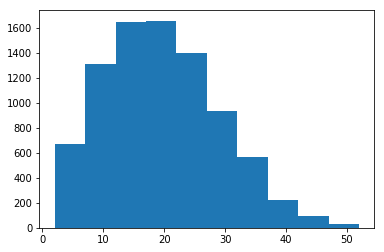

In [198]:
plt.hist(train_lengths)